In [19]:
from collections import OrderedDict
import gc
from pathlib import Path
import pickle
import sys
sys.path.append('..')
from typing import Dict, List, Tuple, Union, Literal
import warnings
import joblib
import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
import polars as pl
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

gc.enable()

In [20]:
KAGGLE = False
MODE:Literal['train', 'test'] = 'train'

In [21]:
if KAGGLE:
    COMPETITION_DIR = Path('/kaggle/input/home-credit-credit-risk-model-stability')
    MODEL_DIR = Path('/kaggle/input/240407-home-credit-test-submit')
    FEATURE_DTYPE_DIR = Path('/kaggle/input/home-credit-enhanced-feature-definitions')
else:
    COMPETITION_DIR = Path('../../data/inputs')
    MODEL_DIR = Path('../../data/models/lgbm-group-tune')
    if not MODEL_DIR.exists():
        MODEL_DIR.mkdir(parents=True)
        MODEL_DIR.joinpath('encoders').mkdir()
        print(MODEL_DIR, 'created')
    FEATURE_DTYPE_DIR = Path('../../data/configs/feature_definitions_dtypes_tables.parquet')

In [22]:
df_features = pd.read_parquet(FEATURE_DTYPE_DIR)
display(df_features)

bool_features = df_features.query('dtype == "Boolean"')
float64_features = df_features.query('dtype == "Float64"')
string_features = df_features.query('dtype == "String"')
date_features = df_features.query('dtype == "Date"')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bool_features['cast_dtype'] = pl.Boolean
    float64_features['cast_dtype'] = pl.Float32
    string_features['cast_dtype'] = pl.String

cast_features = pd.concat([bool_features, float64_features, string_features])
display(cast_features)

,Variable,Description,dtype,tables
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...,Float64,"[train_applprev_1_0, train_applprev_1_1]"
1,actualdpdtolerance_344P,DPD of client with tolerance.,Float64,"[train_static_0_0, train_static_0_1]"
2,addres_district_368M,District of the person's address.,String,[train_person_2]
3,addres_role_871L,Role of person's address.,String,[train_person_2]
4,addres_zip_823M,Zip code of the address.,String,[train_person_2]
...,...,...,...,...
460,totinstallast1m_4525188A,Total amount of monthly instalments paid in th...,Float64,"[train_static_0_0, train_static_0_1]"
461,twobodfilling_608L,Type of application process.,String,"[train_static_0_0, train_static_0_1]"
462,type_25L,Contact type of a person.,String,[train_person_1]
463,typesuite_864L,Persons accompanying the client during the loa...,String,"[train_static_0_0, train_static_0_1]"


,Variable,Description,dtype,tables,cast_dtype
78,contaddr_matchlist_1032L,Indicates whether the contact address is found...,Boolean,[train_person_1],Boolean
79,contaddr_smempladdr_334L,Indicates whether the contact address is the s...,Boolean,[train_person_1],Boolean
174,equalitydataagreement_891L,Flag indicating sudden changes in client's soc...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
175,equalityempfrom_62L,Flag indicating a sudden change in the client'...,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
219,isbidproduct_1095L,Flag indicating if the product is a cross-sell.,Boolean,"[train_static_0_0, train_static_0_1]",Boolean
...,...,...,...,...,...
444,subjectroles_name_541M,Name of subject role in closed credit contract...,String,"[train_credit_bureau_a_2_0, train_credit_burea...",String
445,subjectroles_name_838M,Name of subject role in active credit contract...,String,"[train_credit_bureau_a_2_0, train_credit_burea...",String
461,twobodfilling_608L,Type of application process.,String,"[train_static_0_0, train_static_0_1]",String
462,type_25L,Contact type of a person.,String,[train_person_1],String


In [23]:
def get_depth_paths(load_dir: Path, prefix: Literal['test', 'train']):
    
    assert prefix in ['test', 'train']
    
    depth_paths = OrderedDict()

    depth_paths['static_0'] = []
    depth_paths['static_cb_0'] = []
    depth_paths['applprev_1'] = []
    depth_paths['other_1'] = []
    depth_paths['tax_registry_a_1'] = []
    depth_paths['tax_registry_b_1'] = []
    depth_paths['tax_registry_c_1'] = []
    depth_paths['credit_bureau_a_1'] = []
    depth_paths['credit_bureau_b_1'] = []
    depth_paths['deposit_1'] = []
    depth_paths['person_1'] = []
    depth_paths['debitcard_1'] = []
    depth_paths['applprev_2'] = []
    depth_paths['person_2'] = []
    depth_paths['credit_bureau_a_2'] = []
    depth_paths['credit_bureau_b_2'] = []

    for k in depth_paths.keys():
        depth_paths[k] = sorted(
            [p for p in load_dir.joinpath(f'parquet_files/{prefix}').glob(f'{prefix}_{k}*.parquet')]
        )
    return depth_paths

In [24]:
depth_paths = get_depth_paths(COMPETITION_DIR, MODE)

print(f'the number of {MODE} paths: {sum(len(v1) for v1 in depth_paths.values())}')

the number of train paths: 31


In [29]:
def process_D_features(data: pl.DataFrame, D_columns: List[str]):
    for col in D_columns:
        # 1. convert to datetime from string
        # 2. add y, m, d, wd columns
        # 3. delete original column
        data = data.with_columns([
            pl.col(col).str_to_datetime(format='%Y-%m-%d', errors='coerce').alias(col)
        ])
        data = data.with_columns([
            pl.col(col).year().alias(f'y_{col}'),
            pl.col(col).month().alias(f'm_{col}'),
            pl.col(col).day().alias(f'd_{col}'),
            pl.col(col).weekday().alias(f'wd_{col}')
        ])
        data.drop_in_place(col)
    return data

In [30]:
def merge_dataset(
        base_data: pl.DataFrame,
        depth_paths: Dict[str, List[Path]],
        bool_features: pd.DataFrame,
        float64_features: pd.DataFrame,
        string_features: pd.DataFrame,
        depth: Literal['0', '1', '2', '012'],
    ) -> pd.DataFrame:
    
    assert depth in ['0', '1', '2', '012']
    
    for i, (k, path_list) in enumerate(depth_paths.items()):
        
        if depth == '012':
            pass
        elif depth != k[-1]:
            continue
            
        print(f'loading `{k}`')
        depth_data = []
        for p in path_list:
            sub_data = pl.read_parquet(p).cast({'case_id': pl.Int64})
            if k[-1] == '1':
                sub_data = sub_data.drop('num_group1').group_by('case_id').max().sort('case_id')
            elif k[-1] == '2':
                sub_data = sub_data.drop(['num_group1', 'num_group2']).group_by('case_id').max().sort('case_id')
                
            depth_data.append(sub_data)
            
            print(f'\t{p.stem}: {sub_data.shape}')
            
            del sub_data
            gc.collect()
        
        depth_data = pl.concat(depth_data, how='vertical_relaxed')
        base_data = base_data.join(depth_data, how='left', on='case_id', suffix=f'_{i}')
        
        del depth_data
        gc.collect()
    
    '''
    cast dtypes
    '''
    for _, row in bool_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).fill_null(np.nan).cast(cast_dtype))
        
    for _, row in float64_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
            
    for _, row in string_features[['Variable', 'cast_dtype']].iterrows():
        col = row['Variable']
        cast_dtype = row['cast_dtype']
        if col in base_data.columns:
            base_data = base_data.with_columns(pl.col(col).cast(cast_dtype))
    
    '''
    process D features
    '''
    D_features = [col for col in base_data.columns if col[-1] == 'D']
    base_data = process_D_features(base_data, D_features)
    base_data = base_data.to_pandas()
    return base_data


def encode(depth_data:pd.DataFrame, mode:Literal['train', 'test'], save_dir:Path) -> pd.DataFrame:

    assert mode in ['train', 'test']

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')

    if mode == 'train':
        object_data = []
        print(f'num of object columns: {len(object_columns)}')
        for col in object_columns:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            encoder.fit(depth_data[col].values.reshape(-1, 1))
            # save encoder as joblib
            save_path = save_dir.joinpath(f'encoder_{col}.joblib')
            joblib.dump(encoder, save_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        print(f'num of object columns: {len(object_data)}')
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)
    else:
        object_data = []
        for col in object_columns:
            # load encoder
            load_path = save_dir.joinpath(f'encoder_{col}.joblib')
            encoder = joblib.load(load_path)
            object_data.append(encoder.transform(depth_data[col].values.reshape(-1, 1)).astype(np.float32))
        depth_data.drop(columns=object_columns, inplace=True)
        object_data = np.concatenate(object_data, axis=1)
        object_data = pd.DataFrame(object_data, columns=object_columns)

    return pd.concat([depth_data, object_data], axis=1)


In [27]:
base_data = pl.read_parquet(
    COMPETITION_DIR.joinpath(f'parquet_files/{MODE}/{MODE}_base.parquet')
).cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
    }
)

print(MODE)
display(base_data)

train


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [28]:
depth_data = merge_dataset(
    base_data,
    depth_paths,
    bool_features,
    float64_features,
    string_features,
    '012'
)
display(depth_data)

loading `static_0`
	train_static_0_0: (1003757, 168)
	train_static_0_1: (522902, 168)
loading `static_cb_0`
	train_static_cb_0: (1500476, 53)
loading `applprev_1`
	train_applprev_1_0: (782997, 40)
	train_applprev_1_1: (438525, 40)
loading `other_1`
	train_other_1: (51109, 6)
loading `tax_registry_a_1`
	train_tax_registry_a_1: (457934, 4)
loading `tax_registry_b_1`
	train_tax_registry_b_1: (150732, 4)
loading `tax_registry_c_1`
	train_tax_registry_c_1: (482265, 4)
loading `credit_bureau_a_1`
	train_credit_bureau_a_1_0: (335275, 78)
	train_credit_bureau_a_1_1: (549263, 78)
	train_credit_bureau_a_1_2: (325127, 78)
	train_credit_bureau_a_1_3: (176608, 78)
loading `credit_bureau_b_1`
	train_credit_bureau_b_1: (36500, 44)
loading `deposit_1`
	train_deposit_1: (105111, 4)
loading `person_1`
	train_person_1: (1526659, 36)
loading `debitcard_1`
	train_debitcard_1: (111772, 5)
loading `applprev_2`
	train_applprev_2: (1221522, 4)
loading `person_2`
	train_person_2: (1435105, 9)
loading `credit_bu

AttributeError: 'DataFrame' object has no attribute 'with_column'

In [11]:
depth_data = encode(depth_data, MODE, MODEL_DIR.joinpath('encoders'))
display(depth_data)

num of object columns: 99
num of object columns: 99


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M,relatedpersons_role_762T,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,subjectroles_name_541M,subjectroles_name_838M
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0


In [12]:
# cut columns where NaN ratio is over 0.5
# nan_ratio = depth_data.isnull().mean()
# cut_columns = nan_ratio[nan_ratio > 0.5].index
# depth_data.drop(columns=cut_columns, inplace=True)

# display(depth_data)

# # save cut_columns
# with open(MODEL_DIR.joinpath('cut_columns.pkl'), 'wb') as f:
#     pickle.dump(cut_columns, f)


# # load cut_columns
# with open(MODEL_DIR.joinpath('cut_columns.pkl'), 'rb') as f:
#     cut_columns = pickle.load(f)

In [13]:
if MODE == 'train':
    X, y= (
        depth_data.drop(columns=['case_id', 'target', 'date_decision']),
        depth_data[['case_id', 'target', 'WEEK_NUM']],
    )
else:
    X = depth_data.drop(columns=['case_id', 'date_decision'])
    y = depth_data[['case_id', 'WEEK_NUM']]

In [14]:
X

,MONTH,WEEK_NUM,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,conts_role_79M,empls_economicalst_849M,empls_employer_name_740M,relatedpersons_role_762T,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,subjectroles_name_541M,subjectroles_name_838M
0,201901,0,NaN,NaN,1917.599976,0.000000,0.0,0.0,0.0,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
1,201901,0,NaN,NaN,3134.000000,0.000000,0.0,0.0,0.0,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
2,201901,0,NaN,NaN,4937.000000,0.000000,0.0,0.0,0.0,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
3,201901,0,NaN,NaN,4643.600098,0.000000,0.0,1.0,0.0,2.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
4,201901,0,NaN,NaN,3390.199951,0.000000,0.0,1.0,0.0,0.0,...,5.0,6.0,1.0,10.0,2.0,5.0,5.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,202010,91,0.0,176561.359375,3675.400146,0.000000,0.0,0.0,0.0,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526655,202010,91,0.0,301276.468750,7088.600098,6191.600098,0.0,0.0,5.0,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526656,202010,91,0.0,14232.400391,7788.800293,0.000000,0.0,0.0,0.0,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0
1526657,202010,91,0.0,197371.578125,1195.400024,2827.199951,0.0,0.0,36.0,0.0,...,4.0,5.0,0.0,10.0,1.0,2.0,3.0,3.0,1.0,1.0


In [15]:
# https://zenn.dev/nishimoto/articles/8d575924cc619d に従いoptunaによるチューニングを行う

params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc', 'average_precision'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'max_depth': 5,
    'num_leaves': 31,
    # the folloqwings are hyperparameters to be tuned (use 10% of dataset)
    'feature_fraction': 0.8252389166368176,
    'lambda_l1': 9.791900843835457,
    'lambda_l2': 7.511904149115363,
    'num_leaves': 30,
    'bagging_fraction': 0.5628920345673979,
    'bagging_freq': 7
}

In [17]:
# return logloss
def log_loss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def objective(trial: optuna.Trial, X: pd.DataFrame, y: pd.DataFrame):
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'auc', 'average_precision'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),
        'baggig_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    n_splits = 5
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y['target'], y['WEEK_NUM'])):
        print(f'Fold {fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])

        model:lgb.Booster = lgb.train(
            params,
            train_data,
            num_boost_round=100_000,
            valid_sets=[train_data, valid_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                # lgb.log_evaluation(period=100),
            ]
        )

        oof[valid_idx] = model.predict(X_valid)

        # model_path = MODEL_DIR.joinpath(f'model_{fold}.pkl')
        # with open(model_path, 'wb') as model_path:
        #     pickle.dump(model, model_path)

    return log_loss(y['target'], oof)

def objective_no_cv(trial: optuna.Trial, train_data: lgb.Dataset, valid_data: lgb.Dataset):
    params = {
        'objective': 'binary',
        'metric': ['binary_logloss', 'auc', 'average_precision'],
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'seed': 42,
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 12, 256, 2),
        'baggig_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=100_000,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            # lgb.log_evaluation(period=100),
        ]
    )
    log_loss = model.best_score['valid_1']['binary_logloss']

    return log_loss
    

def optimize(X: pd.DataFrame, y: pd.DataFrame, cv: bool = True)-> optuna.study.Study:
    study = optuna.create_study(
        direction='minimize',
        study_name='lgbm-group-tune',
        storage=f'sqlite:///{MODEL_DIR}/study.db',
        load_if_exists=True,
    )
    if cv:
        study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
    else: 
        X_, _, y_, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y['target']) # reduce data size
        X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_['target'])
        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])
        study.optimize(lambda trial: objective_no_cv(trial, train_data, valid_data), n_trials=100)

    # save study data
    study_path = MODEL_DIR.joinpath('study.pkl')
    with open(study_path, 'wb') as study_path:
        pickle.dump(study, study_path)

    return study

def train(X, y):
    """Train without tuning."""
    n_splits = 5
    skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y['target'], y['WEEK_NUM'])):
        print(f'Fold {fold+1}')

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train['target'])
        valid_data = lgb.Dataset(X_valid, label=y_valid['target'])

        model:lgb.Booster = lgb.train(
            params,
            train_data,
            num_boost_round=100_000,
            valid_sets=[train_data, valid_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=100),
                lgb.log_evaluation(period=100),
            ]
        )

        oof[valid_idx] = model.predict(X_valid)

        model_path = MODEL_DIR.joinpath(f'model_{fold}.pkl')
        with open(model_path, 'wb') as model_path:
            pickle.dump(model, model_path)

    return oof


def evaluate(y_true:pd.DataFrame, y_pred, idx_valid):
    from scripts import data
    evaluator = data.Evaluator(y_true.iloc[idx_valid], y_pred, save_path=MODEL_DIR)

    evaluator.plot_pred(is_log=True)
    evaluator.plot_roc()
    df_gini_weeks, stability = evaluator.plot_gini()
    return df_gini_weeks, stability


def predict(
        models: List[lgb.Booster],
        submit: pd.DataFrame,
        X: pd.DataFrame,
        batch_size: int = 128,
    ) -> pd.DataFrame:
    
    probas = np.zeros(len(X), dtype=np.float32)
    for i in range(0, len(X), batch_size):
        limit = i + batch_size if i + batch_size < len(X) else len(X)
        batch_X = X.iloc[i:limit]
        
        for model in models:
            proba = model.predict(batch_X, num_iteration=model.best_iteration)
            probas[i:limit] += proba.astype(np.float32)
            
            del proba
            gc.collect()
            
        del batch_X
        gc.collect()
    
    probas /= len(models)
    
    submit['score'] = probas
    
    return submit

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.112209	training's auc: 0.850532	training's average_precision: 0.190142	valid_1's binary_logloss: 0.110435	valid_1's auc: 0.850111	valid_1's average_precision: 0.186137
[200]	training's binary_logloss: 0.109167	training's auc: 0.862365	training's average_precision: 0.213601	valid_1's binary_logloss: 0.108885	valid_1's auc: 0.855604	valid_1's average_precision: 0.195183
[300]	training's binary_logloss: 0.107025	training's auc: 0.870293	training's average_precision: 0.233426	valid_1's binary_logloss: 0.1081	valid_1's auc: 0.858477	valid_1's average_precision: 0.200561
[400]	training's binary_logloss: 0.105222	training's auc: 0.876609	training's average_precision: 0.252396	valid_1's binary_logloss: 0.107763	valid_1's auc: 0.859553	valid_1's average_precision: 0.203197
[500]	training's binary_logloss: 0.103585	training's auc: 0.882221	training's average_precision: 0.270958	valid_1's binar

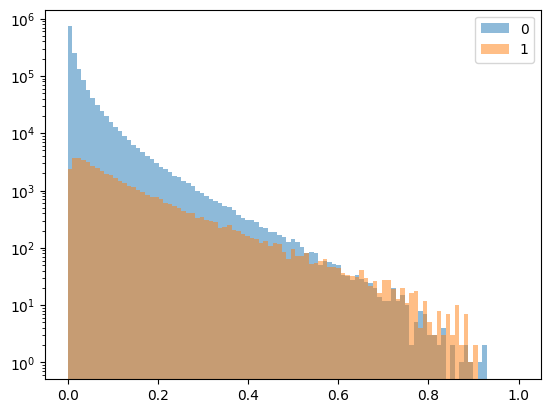

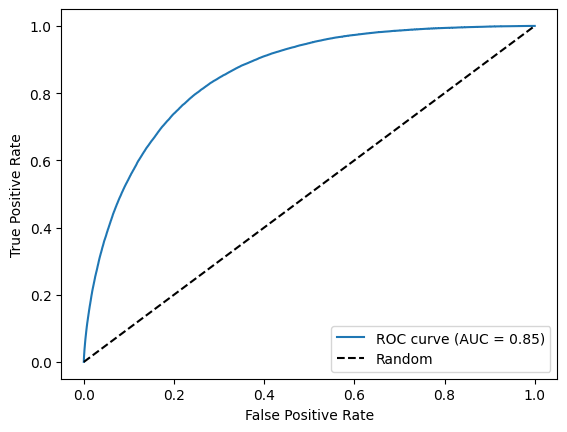

0.6886318308286218


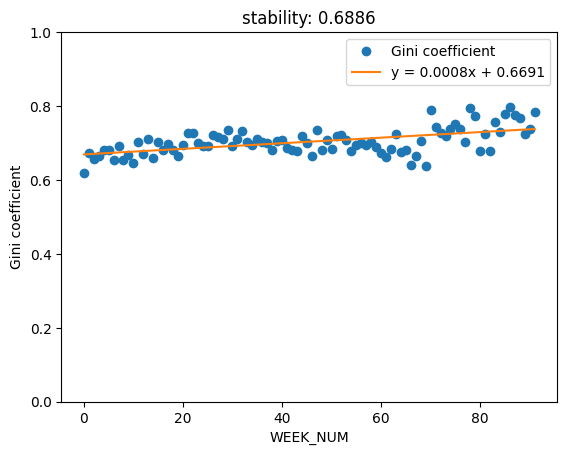

,WEEK_NUM,Gini
0,0,0.617798
1,1,0.672679
2,2,0.657392
3,3,0.663564
4,4,0.680238
...,...,...
87,87,0.776610
88,88,0.766446
89,89,0.725012
90,90,0.739010


0.6886318308286218

In [18]:
if MODE == 'train':
    # study = optimize(X, y, cv=False)
    # print(study.best_params)

    # # retrain with the best params
    # params.update(study.best_params)
    oof = train(X, y)
    df_gini_weeks, stability = evaluate(y, oof, y.index)
    display(df_gini_weeks)
    display(stability)

else:
    models = []
    for i in range(5):
        model_path = MODEL_DIR.joinpath(f'model_{i}.pkl')
        with open(model_path, 'rb') as model_path:
            model = pickle.load(model_path)
            models.append(model)
    submit = pd.read_csv(COMPETITION_DIR.joinpath('sample_submission.csv'))
    submit = predict(models, submit, X)
    submit.to_csv(Path('submission.csv'), index=False)
    display(submit)

In [6]:
# reload study from sql
study = optuna.load_study(
    study_name='lgbm-group-tune',
    storage=f'sqlite:///{MODEL_DIR}/study.db',
)

In [7]:
study.best_params

{'feature_fraction': 0.8252389166368176,
 'lambda_l1': 9.791900843835457,
 'lambda_l2': 7.511904149115363,
 'num_leaves': 30,
 'bagging_fraction': 0.5628920345673979,
 'bagging_freq': 7}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_edf(study)